# Cleaning zomatoData csv  and some Analysis

In [2112]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2113]:
df = pd.read_csv("zomato_extracted_data_csv/zomato_extracted_data.csv",encoding = "ISO-8859-1",na_values=["NA",'-'])

In [2114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6147 entries, 0 to 6146
Data columns (total 23 columns):
restaurant_link           6147 non-null object
restaurant_ID             6147 non-null int64
restaurant_name           6147 non-null object
locality                  6147 non-null object
restaurant_category       6142 non-null object
zomato_gold               347 non-null object
discounts                 738 non-null object
photos_taken              6147 non-null int64
rating                    5328 non-null float64
votes                     5310 non-null float64
cuisines                  6147 non-null object
approx_cost_for_2         6147 non-null int64
opening_timings           6143 non-null object
address                   6041 non-null object
latitude                  5682 non-null float64
longitude                 5682 non-null float64
more_info                 6147 non-null object
featured_in               761 non-null object
known_for                 290 non-null object
mos

In [2115]:
df.shape

(6147, 23)

In [2116]:
df = df.drop_duplicates("restaurant_ID",keep='first')

In [2117]:
df.shape

(5637, 23)

In [2118]:
def listToTuple(reviews):
    if isinstance(reviews,str):
        reviewList = ast.literal_eval(reviews)
        if len(reviewList)>0 and isinstance(reviewList,list):
            tup = (reviewList[0],reviewList[1:])
            return tuple(tup)

In [2119]:
df["most_liked_Food"] = df["most_liked_Food"].apply(listToTuple)    
df["most_liked_Service"] = df["most_liked_Service"].apply(listToTuple)
df["most_liked_Look & Feel"] = df["most_liked_Look & Feel"].apply(listToTuple)

In [2120]:
def formatTime(timing):
    if isinstance(timing,str):
        if timing is np.nan or timing == "[]":
            return "NA"
        timings = ast.literal_eval(timing)
        newtime = ['12:00' if timed == '12noon' else '00:00' if timed == "12midnight" else timed if ("24" in timed) else datetime.strptime(timed,'%I%p').strftime('%H:%M') if len(timed)<5 else datetime.strptime(timed,'%I:%M%p').strftime('%H:%M') for timed in timings]
        return newtime

In [2121]:
df["opening_timings"] = df["opening_timings"].apply(formatTime)

In [2122]:
df['cuisines'] = [x.split(",") if isinstance(x,str) else x for x in df["cuisines"]]

In [2123]:
df.to_csv("zomato_clean_data_csv/zomato_clean_data"+".csv",index=False)

In [2124]:
#reading the new clean data
df = pd.read_csv("zomato_clean_data_csv/zomato_clean_data.csv")

In [2125]:
df.index = df["restaurant_ID"]
df.drop(["restaurant_ID"],axis=1,inplace=True)

In [2126]:
df.shape

(5637, 22)

# Some Interesting Insights#

# 1.Different Restaurant categories and their counts

In [2127]:
plt.style.use('ggplot')

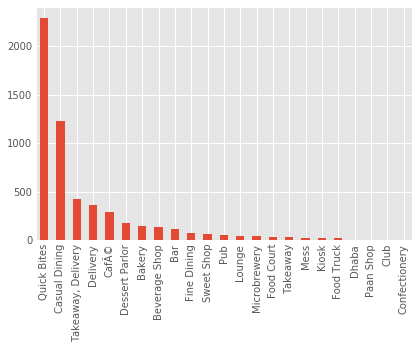

In [2128]:
df["restaurant_category"].value_counts().plot.bar()

In [2129]:
#Quick bites and Casual dining are the most common of all restaurant categories

# 2. Most Unique cuisines

In [2130]:
df['cuisines_new'] = df['cuisines'].apply(ast.literal_eval)

In [2131]:
cuisines_series = df['cuisines_new'].apply(pd.Series).stack().reset_index(drop=True)

In [2132]:
cuisines_series.value_counts(ascending = True)

Raw Meats           1
Nepalese            1
African             1
 Moroccan           1
 Peruvian           1
                 ... 
 Fast Food        616
South Indian      730
 North Indian    1098
North Indian     1537
 Chinese         1694
Length: 175, dtype: int64

In [2052]:
#Raw meats,Nepalese are some of rare cuisines

# 3.Which locality has maximum restuarants which are in featured in 'newly opened'?

In [2133]:
dffeatured = df.dropna(subset=['featured_in'])

In [2134]:
dffeatured['featured_in'].apply(ast.literal_eval)

restaurant_ID
56618                     [Great Buffets, Bengaluru's Finest]
19122613                               [Sneak Peek Bengaluru]
19203051    [Sneak Peek Bengaluru, Corporate Favorites, Gr...
18853706                [Bengaluru's Finest, Outdoor Seating]
18706428    [Sunday Brunches, Live Sports Screenings, Beng...
                                  ...                        
53185                                     [Comfort In A Cup!]
58239                                [Live Sports Screenings]
18894358        [Food Hygiene Rated Restaurants in Bengaluru]
18538046                                           [Rooftops]
18601058                                      [Beer in a Bar]
Name: featured_in, Length: 739, dtype: object

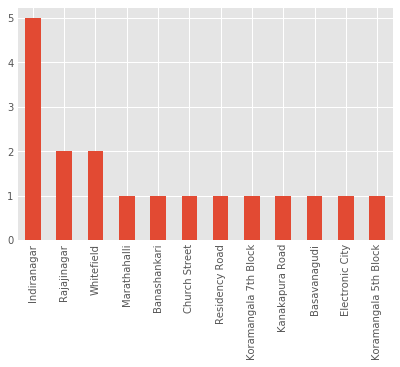

In [2135]:
dffeatured["locality"][dffeatured['featured_in'].apply(lambda x: 'Newly Opened' in x)].value_counts().plot.bar()

In [2101]:
#3. Insight 

# 4.Average cost of 2 for a restaurant category 

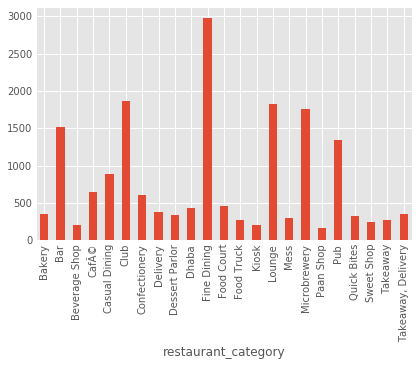

In [2136]:
df.groupby("restaurant_category")['approx_cost_for_2'].mean().plot.bar()

In [2009]:
#Insight

# 5.Average restaurant rating in locality

In [2137]:
df['rating'] = df['rating'].astype(float)

In [2138]:
dfmeanratings = df.groupby("locality")['rating'].mean()
dfmeanratings.sort_values(ascending=False)

locality
Sankey Road              4.225000
Lavelle Road             4.143333
Church Street            4.095833
Race Course Road         4.084211
Koramangala 5th Block    4.061290
                           ...   
CV Raman Nagar           3.526087
Ejipura                  3.520000
Uttarahalli              3.515385
Bommanahalli             3.500000
City Market              3.476923
Name: rating, Length: 96, dtype: float64

In [2012]:
# 5.Insight

# 6.Restaurant categories having highest and lowest ratings

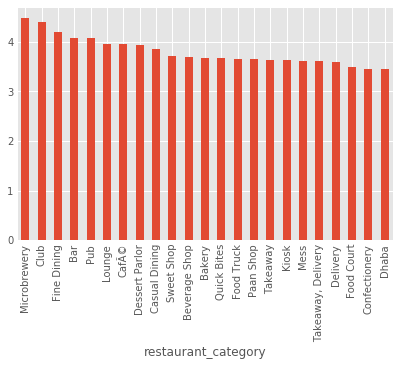

In [2139]:
dfcatratings = df.groupby("restaurant_category")['rating'].mean()
dfcatratings.sort_values(ascending=False).plot.bar()

# 7.In a nutshell,what is liked the most in top 2 restaurant categories.(Club, Microbreweries)

In [2140]:
topCategories = ['Club','Microbrewery']
dfLikedInTopCat = df[df['restaurant_category'].isin(topCategories)]

def combineFeatureText(series):
    text = []
    for i in series.iteritems():
        for j in i:
            if type(j) is tuple:
                text = text + j[1]
    return text    

dfLikedInTopCat = dfLikedInTopCat.dropna(subset=['most_liked_Food'])
dfLikedInTopCat['most_liked_Food'] = dfLikedInTopCat['most_liked_Food'].apply(ast.literal_eval)
mostLikedFoodText = dfLikedInTopCat.groupby('restaurant_category')['most_liked_Food'].agg(combineFeatureText)

dfLikedInTopCat = dfLikedInTopCat.dropna(subset=['most_liked_Service'])
dfLikedInTopCat['most_liked_Service'] = dfLikedInTopCat['most_liked_Service'].apply(ast.literal_eval)
mostLikedServiceText = dfLikedInTopCat.groupby('restaurant_category')['most_liked_Service'].agg(combineFeatureText)

dfLikedInTopCat = dfLikedInTopCat.dropna(subset=['most_liked_Look & Feel'])
dfLikedInTopCat['most_liked_Look & Feel']= dfLikedInTopCat['most_liked_Look & Feel'].apply(ast.literal_eval)
mostLikedLooknFeelText = dfLikedInTopCat.groupby('restaurant_category')['most_liked_Look & Feel'].agg(combineFeatureText)

mostLikedCombined = mostLikedFoodText+ mostLikedServiceText +mostLikedLooknFeelText


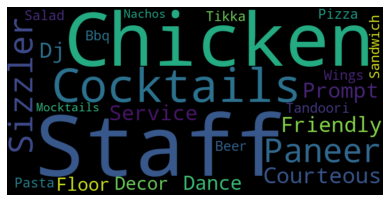

In [2141]:
liked_text = ' '.join(review for review in mostLikedCombined["Club"])

wordcloud = WordCloud(width=800, height=400).generate(liked_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

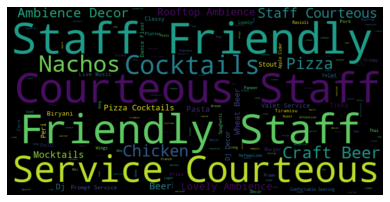

In [2142]:
liked_text = ' '.join(review for review in mostLikedCombined["Microbrewery"])

wordcloud = WordCloud(width=800, height=400).generate(liked_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 8.Linear regression between photos taken and votes

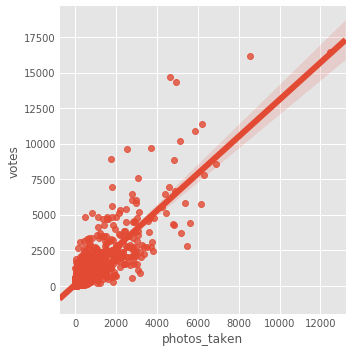

In [2143]:
sns.lmplot('photos_taken','votes',data=df)

# 9.How Zomato benefits affects ratings of a particular restaurant category in any locality 

In [2144]:
dfZomato= df.groupby(['locality','restaurant_category','zomato_gold'])['rating'].mean()
dfZomato

locality       restaurant_category  zomato_gold
BTM            Bar                  zomato gold    3.600000
               Casual Dining        zomato gold    4.150000
               Dessert Parlor       zomato gold    4.400000
Banashankari   Casual Dining        zomato gold    3.700000
               Lounge               zomato gold    3.900000
                                                     ...   
Whitefield     Pub                  zomato gold    4.200000
Wilson Garden  Casual Dining        zomato gold    3.900000
Yelahanka      Casual Dining        zomato gold    4.033333
Yeshwantpur    Bar                  zomato gold    3.700000
               Casual Dining        zomato gold    3.833333
Name: rating, Length: 155, dtype: float64

In [2145]:
dfNoZomato = df.groupby(['locality','restaurant_category'])['rating'].mean()
dfNoZomato

locality     restaurant_category
BTM          Bakery                 3.660000
             Bar                    3.600000
             Beverage Shop          3.690909
             CafÃ©                  3.769231
             Casual Dining          3.805882
                                      ...   
Yeshwantpur  Pub                    4.100000
             Quick Bites            3.621429
             Sweet Shop             3.450000
             Takeaway                    NaN
             Takeaway, Delivery     3.400000
Name: rating, Length: 820, dtype: float64

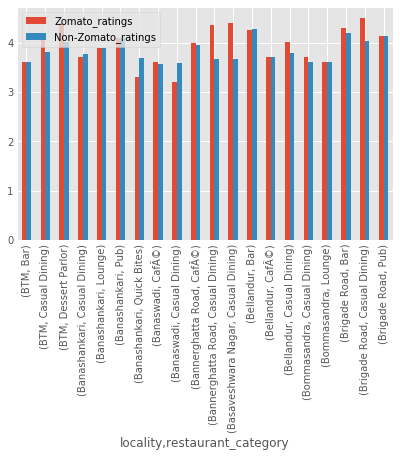

In [2146]:
mergeddf = pd.merge(dfZomato,dfNoZomato,how ='left',on=['locality','restaurant_category'])
slicedMergeddf = mergeddf[0:20] #slice dataframe
ax = slicedMergeddf.plot.bar()
ax.legend(["Zomato_ratings", "Non-Zomato_ratings"]);


# 10.Insight on Positive & negative sentiments on days of a week

In [1853]:
#df['reviews_new'] = df['reviews'].apply(ast.literal_eval)

In [1970]:
#review_series = df['reviews_new'].apply(pd.Series).stack().reset_index(drop=True)

In [1983]:
# p = [i[0:3] for i in review_series]

# cols = ["ReviewDay","Positive sentiment","Negative sentiment"]
# for i,obj in enumerate(p):
#     obj[0] = datetime.strptime(obj[0], '%Y-%m-%d %H:%M:%S').strftime('%A')
    
# #rrr = pd.Series(p)
# #review_s.value_counts()

# newDF = pd.DataFrame(p,columns=cols)
# newDF.head(20)


In [1954]:
#review_s = rrr.apply(pd.Series).stack().reset_index(drop=True)

In [1955]:
#review_s

In [1984]:
#newDF.head(19)

In [1931]:
#dicty = {"positive":[20,10],"negative":[50,60]}

In [1982]:
# y = pd.DataFrame(dicty)
# y

In [1981]:
#y.plot.bar()